<a href="https://colab.research.google.com/github/saraswatnitin/CausalInferenceDiscoverywithML/blob/main/13_Causal_Discovery_Machine_Learning_Assumptions_Applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gcastle==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 4.0 MB/s eta 0:00:00


In [7]:
!pip install --force-reinstall networkx==2.8.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [1]:
#We need to restart the runtime to ensure the correct version is picked up

In [2]:


import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

from scipy import linalg

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

In [3]:


COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Chapter 13

**Causal discovery and machine learning – from assumptions to applications**



In [4]:




# Set random seed
SEED = 18
np.random.seed(SEED)

## Introduction to gCastle

### Synthetic data in gCastle

In [6]:

print(nx.__version__) # this should show as 2.8.8

2.8.8


In [7]:

# Generate a scale-free adjacency matrix
adj_matrix = DAG.scale_free(
    n_nodes=10,
    n_edges=17,
    seed=SEED
)

In [8]:

adj_matrix

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]])

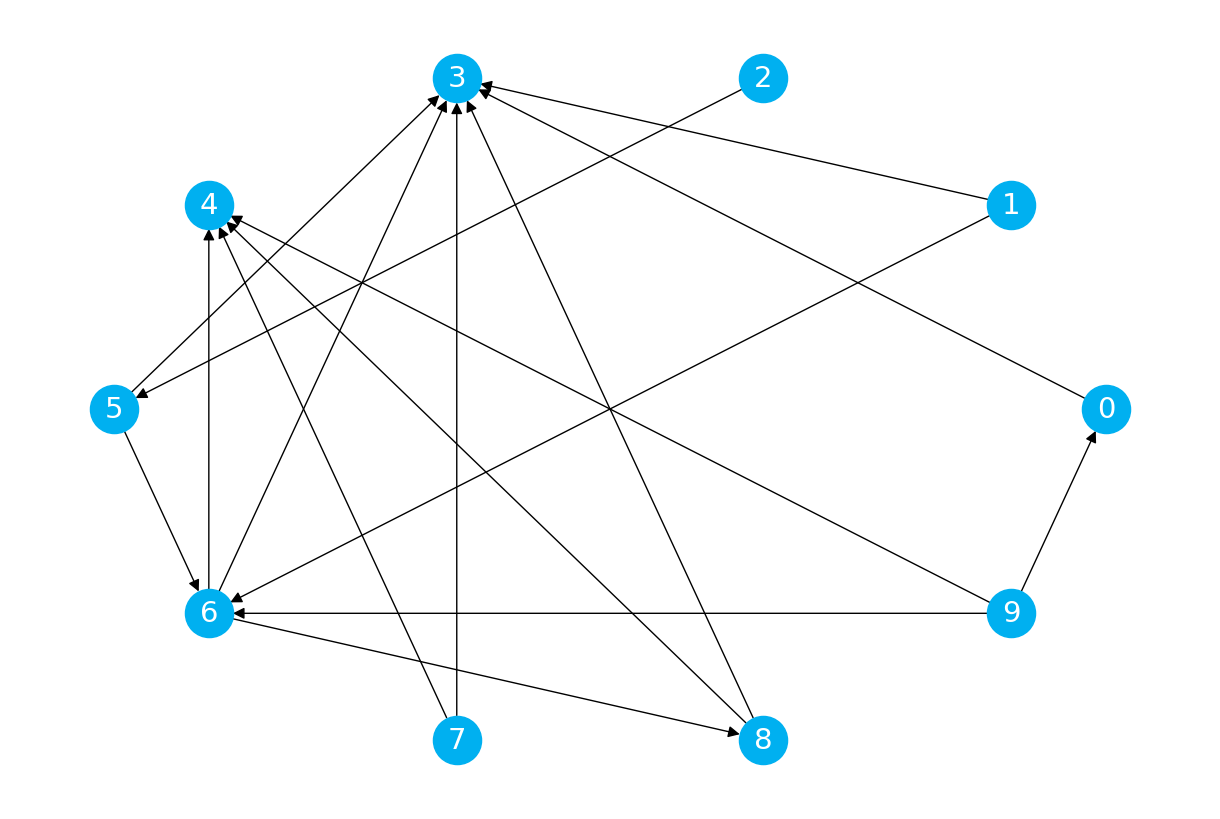

In [9]:


# Visualize the adjacency matrix
g = nx.DiGraph(adj_matrix)

plt.figure(figsize=(12, 8))
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

In [10]:
dataset = IIDSimulation(
    W=adj_matrix,
    n=10000,
    method='linear',
    sem_type='gauss'
)

In [11]:


# Access the generated data
dataset.X

array([[ 0.203,  0.47 , -0.545, ...,  0.437, -3.953, -0.583],
       [ 0.95 ,  0.691,  0.257, ...,  1.331,  3.605,  0.534],
       [-0.879,  1.048,  0.634, ..., -0.396,  0.326, -1.056],
       ...,
       [-0.916, -0.024, -0.292, ...,  1.25 , -3.983, -1.299],
       [-0.152, -0.355, -0.598, ...,  0.183, -2.572, -1.282],
       [-2.538,  0.839, -0.466, ...,  0.721, -0.515, -2.734]])

### Fitting your first causal discovery model

In [12]:

# Instantiate the model
pc = PC()

In [13]:

# Fit the model
pc.learn(dataset.X)

In [14]:
pred_dag = pc.causal_matrix
pred_dag

Tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 0, 0]])

### Visualizing the model

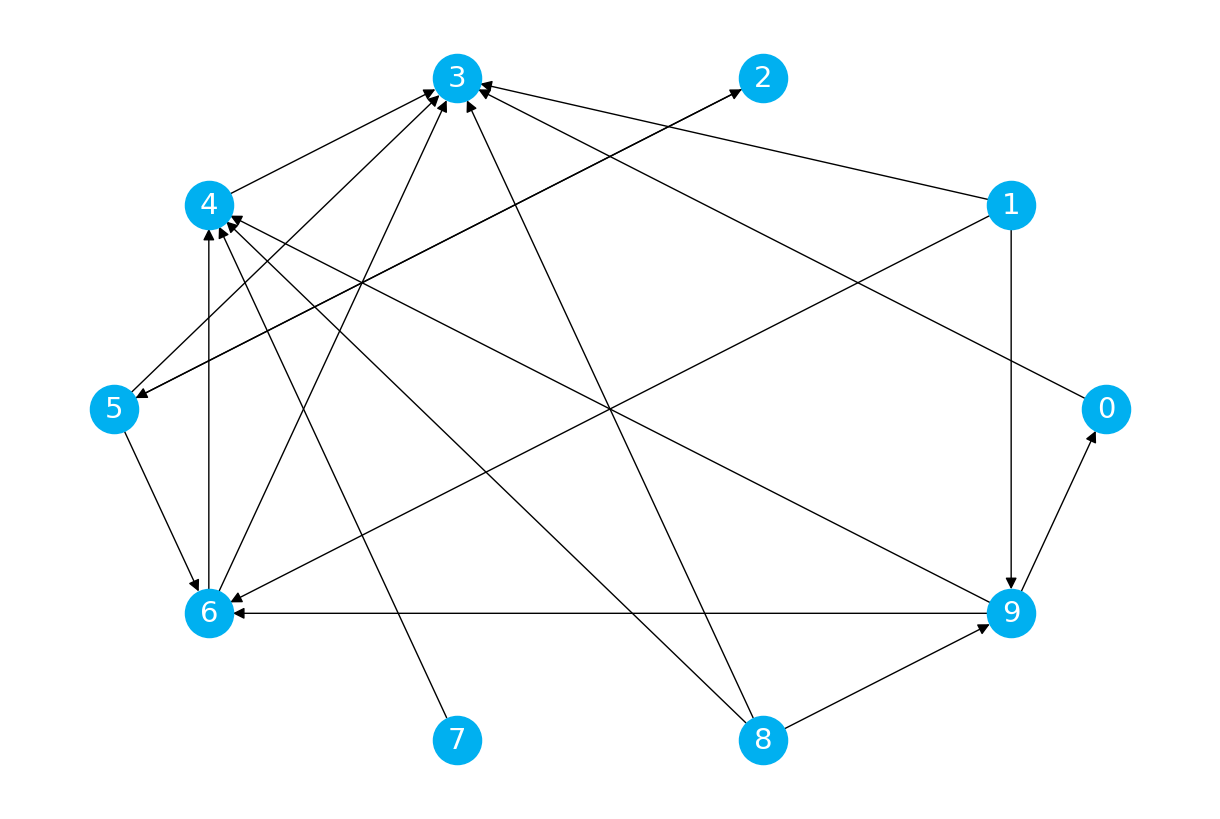

In [15]:
g_pred = nx.DiGraph(pred_dag)

plt.figure(figsize=(12, 8))
nx.draw(
    G=g_pred,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

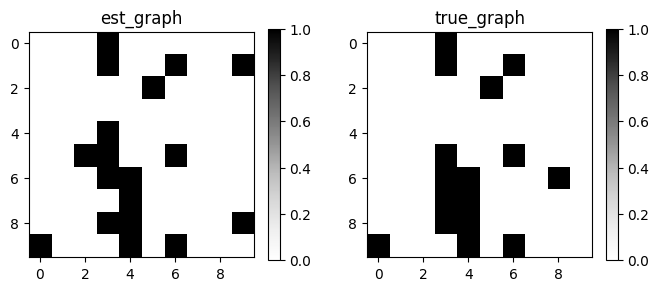

In [16]:
GraphDAG(
    est_dag=pred_dag,
    true_dag=adj_matrix)

plt.show()

### Model evaluation metrics

In [17]:

metrics = MetricsDAG(
    B_est=pred_dag,
    B_true=adj_matrix)
#What are the metrics defined in MetricsDAG ? F1 score is  one of them

In [20]:
metrics.metrics

{'fdr': 0.1765,
 'tpr': 0.875,
 'fpr': 0.1034,
 'shd': 5,
 'nnz': 17,
 'precision': 0.7778,
 'recall': 0.875,
 'F1': 0.8235,
 'gscore': 0.625}

In [18]:
metrics.metrics['F1']

0.8235

In [21]:

def get_n_undirected(g):

    total = 0

    for i in range(g.shape[0]):
        for j in range(g.shape[0]):
            if (g[i, j] == 1) and (g[i, j] == g[j, i]):
                total += .5

    return total

In [22]:

get_n_undirected(pred_dag)

1.0

In [23]:

np.tril(pred_dag)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 1, 0, 0, 0]])

## Constraint-based causal discovery

In [24]:

# Build a DAG adj matrix
pc_dag = np.array([
    [0, 0, 1, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
])

In [25]:

# Generate data from this DAG
N = 1000

p = np.random.randn(N)
q = np.random.randn(N)

r = p + q + .1 * np.random.randn(N)
s = .7 * r + .1 * np.random.randn(N)

# To matrix
pc_dataset = np.vstack([p, q, r, s]).T

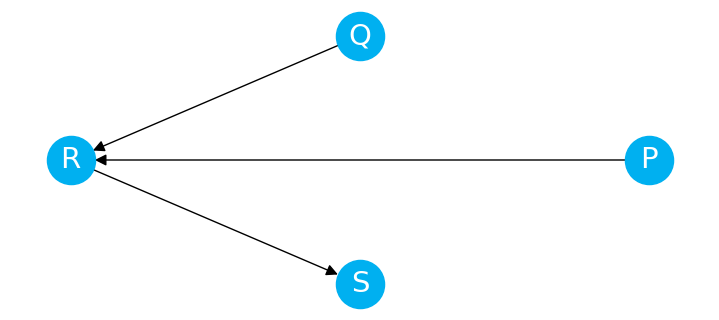

In [26]:


# Plot the original graph

# Get learned graph
true_graph = nx.DiGraph(pc_dag)

# Relabel the nodes
MAPPING = {k: v for k, v in zip(range(4), ['P', 'Q', 'R', 'S'])}
true_graph = nx.relabel_nodes(true_graph, MAPPING, copy=True)

plt.figure(figsize=(7, 3))
nx.draw(
    G=true_graph,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(true_graph)
)

### PC

In [27]:

# Initialize PC
pc = PC()

# Fit
pc.learn(pc_dataset)

# Display the learned matrix
pc.causal_matrix

Tensor([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0]])

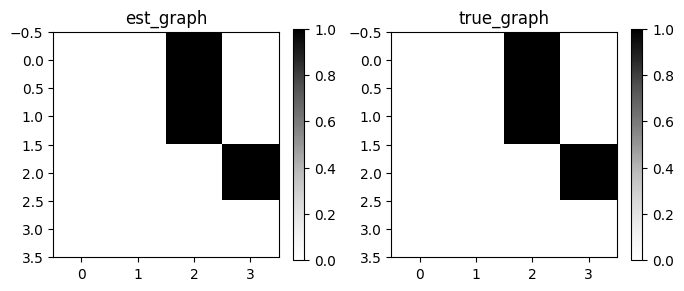

In [28]:

# Visualize
GraphDAG(
    est_dag=pc.causal_matrix,
    true_dag=pc_dag)

plt.show()

In [29]:
# Get metrics
MetricsDAG(
    B_est=pc.causal_matrix,
    B_true=pc_dag
).metrics

{'fdr': 0.0,
 'tpr': 1.0,
 'fpr': 0.0,
 'shd': 0,
 'nnz': 3,
 'precision': 1.0,
 'recall': 1.0,
 'F1': 1.0,
 'gscore': 1.0}

### PC-stable

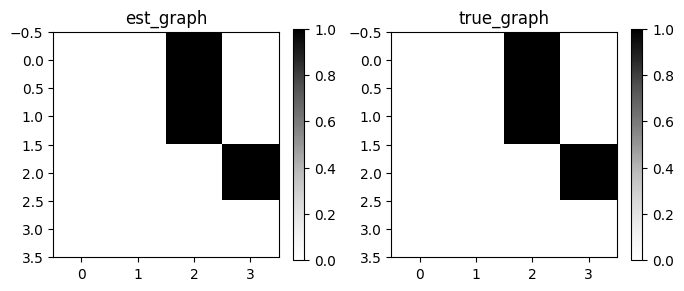

In [30]:

# PC-stable
pc_stable = PC(variant='stable')

# Fit
pc_stable.learn(pc_dataset)

# Visualize
GraphDAG(
    est_dag=pc_stable.causal_matrix,
    true_dag=pc_dag)

plt.show()

### PC-parallel

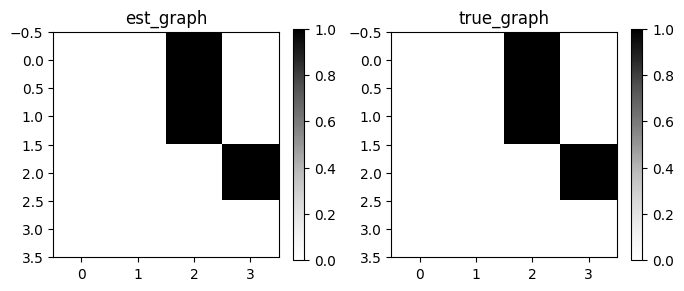

In [31]:

# PC-stable
pc_parallel = PC(variant='parallel')

# Fit
pc_parallel.learn(pc_dataset)

# Visualize
GraphDAG(
    est_dag=pc_parallel.causal_matrix,
    true_dag=pc_dag)

plt.show()

### PC with categorical data

In [32]:

# Generate the data
a = np.random.binomial(4, .5, N)
b = np.random.binomial(4, .5, N)
c = ((a + b + np.random.normal(0, 1, N)) > 2).astype(int)

# To matrix
pc_cat_dataset = np.vstack([a, b, c]).T

In [33]:

pc_cat = PC(ci_test='chi2')
#Every statistical test will test a hypothesis usually referred to as Null Hypothesis and will take help of probability density/Probability mass functions
 #(called Distributions to answer them - The lower the chance of  )

In [34]:

pc_cat.learn(pc_cat_dataset)

In [35]:

pc_cat.causal_matrix

Tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 0]])

### PC with alternative independence tests

In [36]:

from castle.common.independence_tests import CITest

In [37]:

pc_cat_alt = PC(ci_test=CITest.cressie_read)

In [38]:

pc_cat_alt.learn(pc_cat_dataset)

In [39]:

pc_cat_alt.causal_matrix

Tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 0]])

## Score-based causal discovery

In [40]:

# Instantiate GES
ges = GES(criterion='bic')

In [41]:


# Train
ges.learn(pc_dataset)

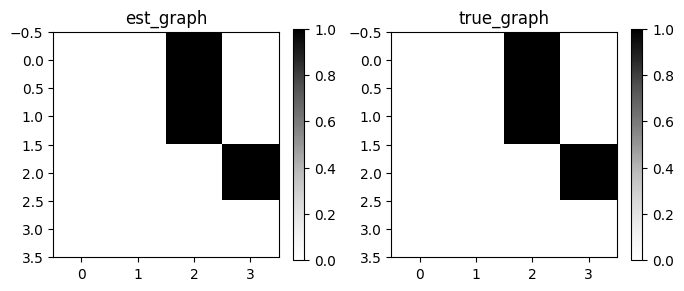

In [42]:


# Visualize
GraphDAG(
    est_dag=ges.causal_matrix,
    true_dag=pc_dag)

plt.show()

## Function-based casual discovery

### ANM model (from scratch)

In [43]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.


In [44]:

# Define helpers
from pygam import LinearGAM


class GAM:

    def __init__(self, n_splines):
        self.n_splines = n_splines

    def fit(self, x, y):
        # Check `x` dimensionality
        x = np.array(x)
        assert len(x.shape) == 2, f'`x` should be 2D array. Received {len(x.shape)} dimensional array.'

        # Fit the model
        self.model = LinearGAM(n_splines=self.n_splines).gridsearch(x, y)

    def predict(self, x):
        return self.model.predict(x)

In [45]:

# Create data
x = np.random.randn(1000)
y = x**3 + np.random.randn(1000)

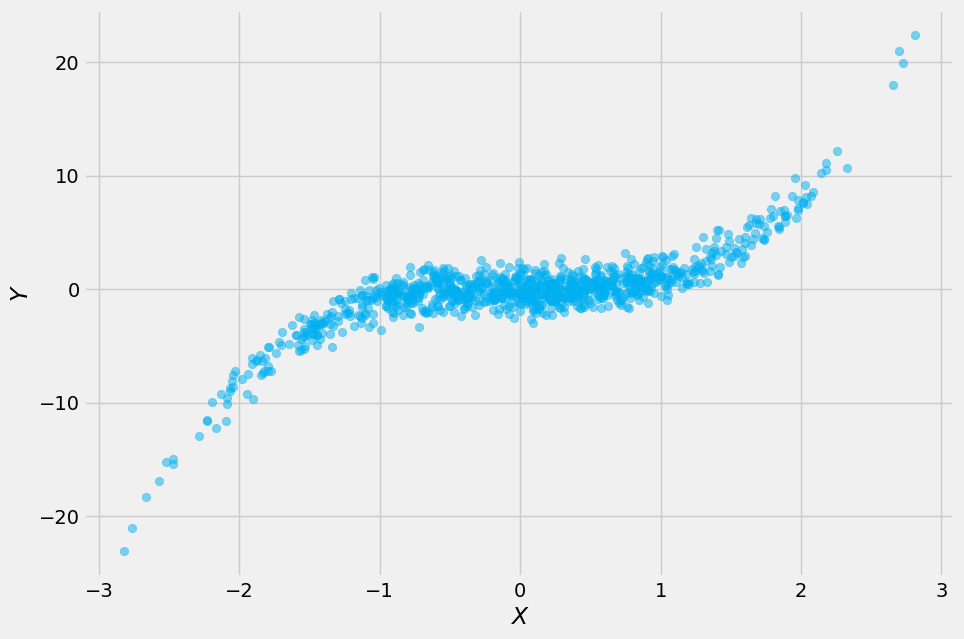

In [46]:

# Plot data
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10, 7))

plt.scatter(x, y, alpha=.5, color=COLORS[0])

plt.xlabel('$X$')
plt.ylabel('$Y$')

plt.show()

In [47]:

# Define params
n_splines = 150

# Instantiate the models
model_xy = GAM(n_splines=n_splines)
model_yx = GAM(n_splines=n_splines)

# Fit the models
model_xy.fit(x.reshape(-1, 1), y)
model_yx.fit(y.reshape(-1, 1), x)

# Generate predictions
y_pred = model_xy.predict(x.reshape(-1, 1))
x_pred = model_yx.predict(y.reshape(-1, 1))

100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


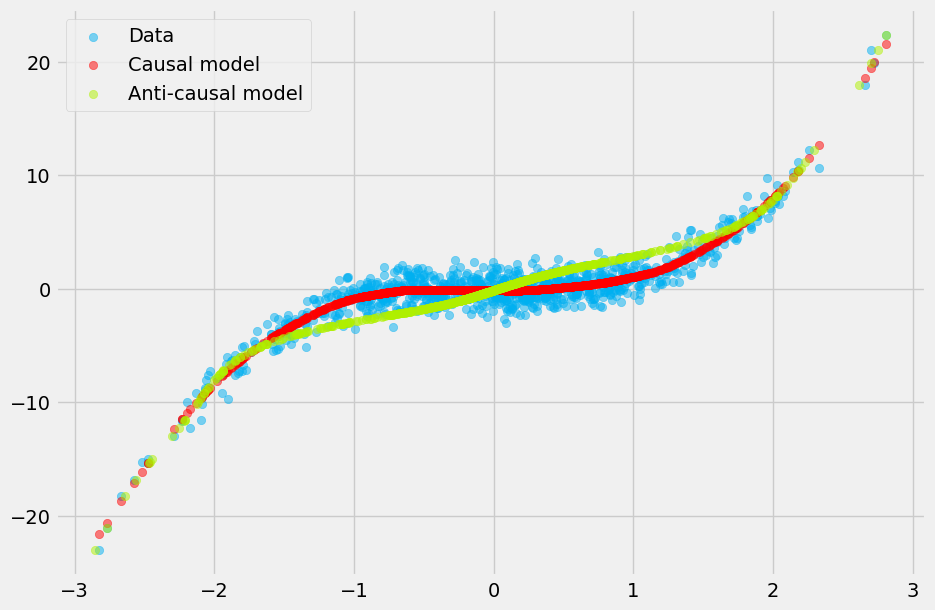

In [48]:

# Visualize the fitted model
plt.figure(figsize=(10, 7))
plt.scatter(x, y, alpha=.5, color=COLORS[0], label='Data')
plt.scatter(x, y_pred, alpha=.5, color=COLORS[1], label='Causal model')
plt.scatter(x_pred, y, alpha=.5, color=COLORS[2], label='Anti-causal model')
plt.legend()
plt.show()

In [50]:

# Get the residuals
residuals_xy = y - y_pred
residuals_yx = x - x_pred

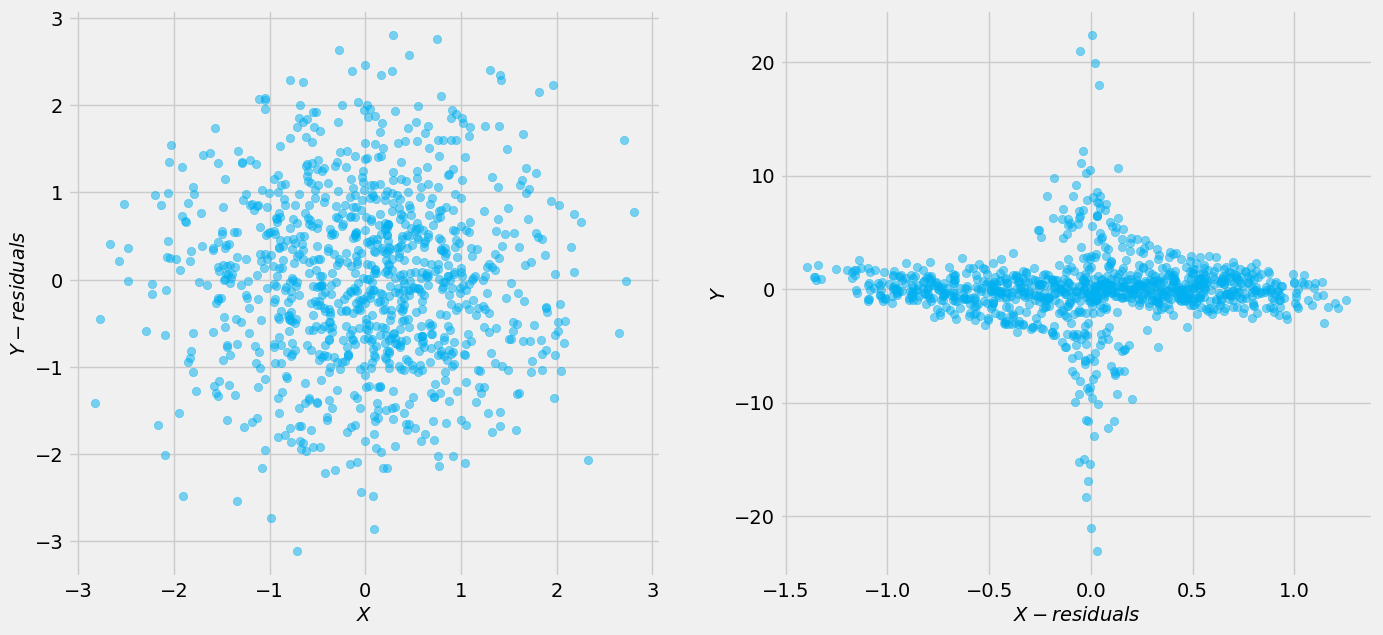

In [51]:

plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.scatter(x, residuals_xy, alpha=.5, color=COLORS[0])
plt.xlabel('$X$', fontsize=14)
plt.ylabel('$Y-residuals$', fontsize=14)

plt.subplot(122)
plt.scatter(residuals_yx, y, alpha=.5, color=COLORS[0])
plt.xlabel('$X-residuals$', fontsize=14)
plt.ylabel('$Y$', fontsize=14)

plt.show()

In [52]:

# Compute HSIC
is_indep_xy = hsic_test(
    x = x.reshape(-1, 1),
    y = residuals_xy.reshape(-1, 1),
    alpha=.05
)

is_indep_yx = hsic_test(
    x = y.reshape(-1, 1),
    y = residuals_yx.reshape(-1, 1),
    alpha=.05
)

In [53]:

is_indep_xy, is_indep_yx

(1, 0)

### ANM model (gCastle)

In [54]:

# Instantiate
anm = ANMNonlinear(alpha=.1)

In [55]:

# Train
nonlinear_dataset = np.vstack([x, y]).T
anm.learn(nonlinear_dataset)

In [56]:

anm.causal_matrix

Tensor([[0., 0.],
        [0., 0.]])

The model fails to find the causal direction. The difference in the results might be caused by the fact that gCastle's implementation is based on Gaussian process regression rather than GAM.

## LiNGAM time!

In [57]:
# Generate data
SAMPLE_SIZE = 1000

x_gauss = np.random.normal(0, 1, SAMPLE_SIZE)
y_gauss = x_gauss + 0.3 * np.random.normal(0, 1, SAMPLE_SIZE)

x_ngauss = np.random.uniform(0, 1, SAMPLE_SIZE)
y_ngauss = x_ngauss + 0.3 * np.random.uniform(0, 1, SAMPLE_SIZE)

In [58]:

# Fit regressions
results = {}

for name, v in zip(['Gaussian', 'non-Gaussian'], [(x_gauss, y_gauss), (x_ngauss, y_ngauss)]):

    for direction in ['y ~ x', 'x ~ y']:

        predictor_idx = 0
        target_idx = 1

        if direction.startswith('x'):
            predictor_idx, target_idx = target_idx, predictor_idx

        key = f'{name} | {direction}'
        print(key)

        # Fit the model
        lr = LinearRegression()
        lr.fit(v[predictor_idx].reshape(-1, 1), v[target_idx])

        # Predict
        preds = lr.predict(v[predictor_idx].reshape(-1, 1))

        # Compute residuals
        residuals = v[target_idx] - preds

        results[key] = preds, residuals

Gaussian | y ~ x
Gaussian | x ~ y
non-Gaussian | y ~ x
non-Gaussian | x ~ y


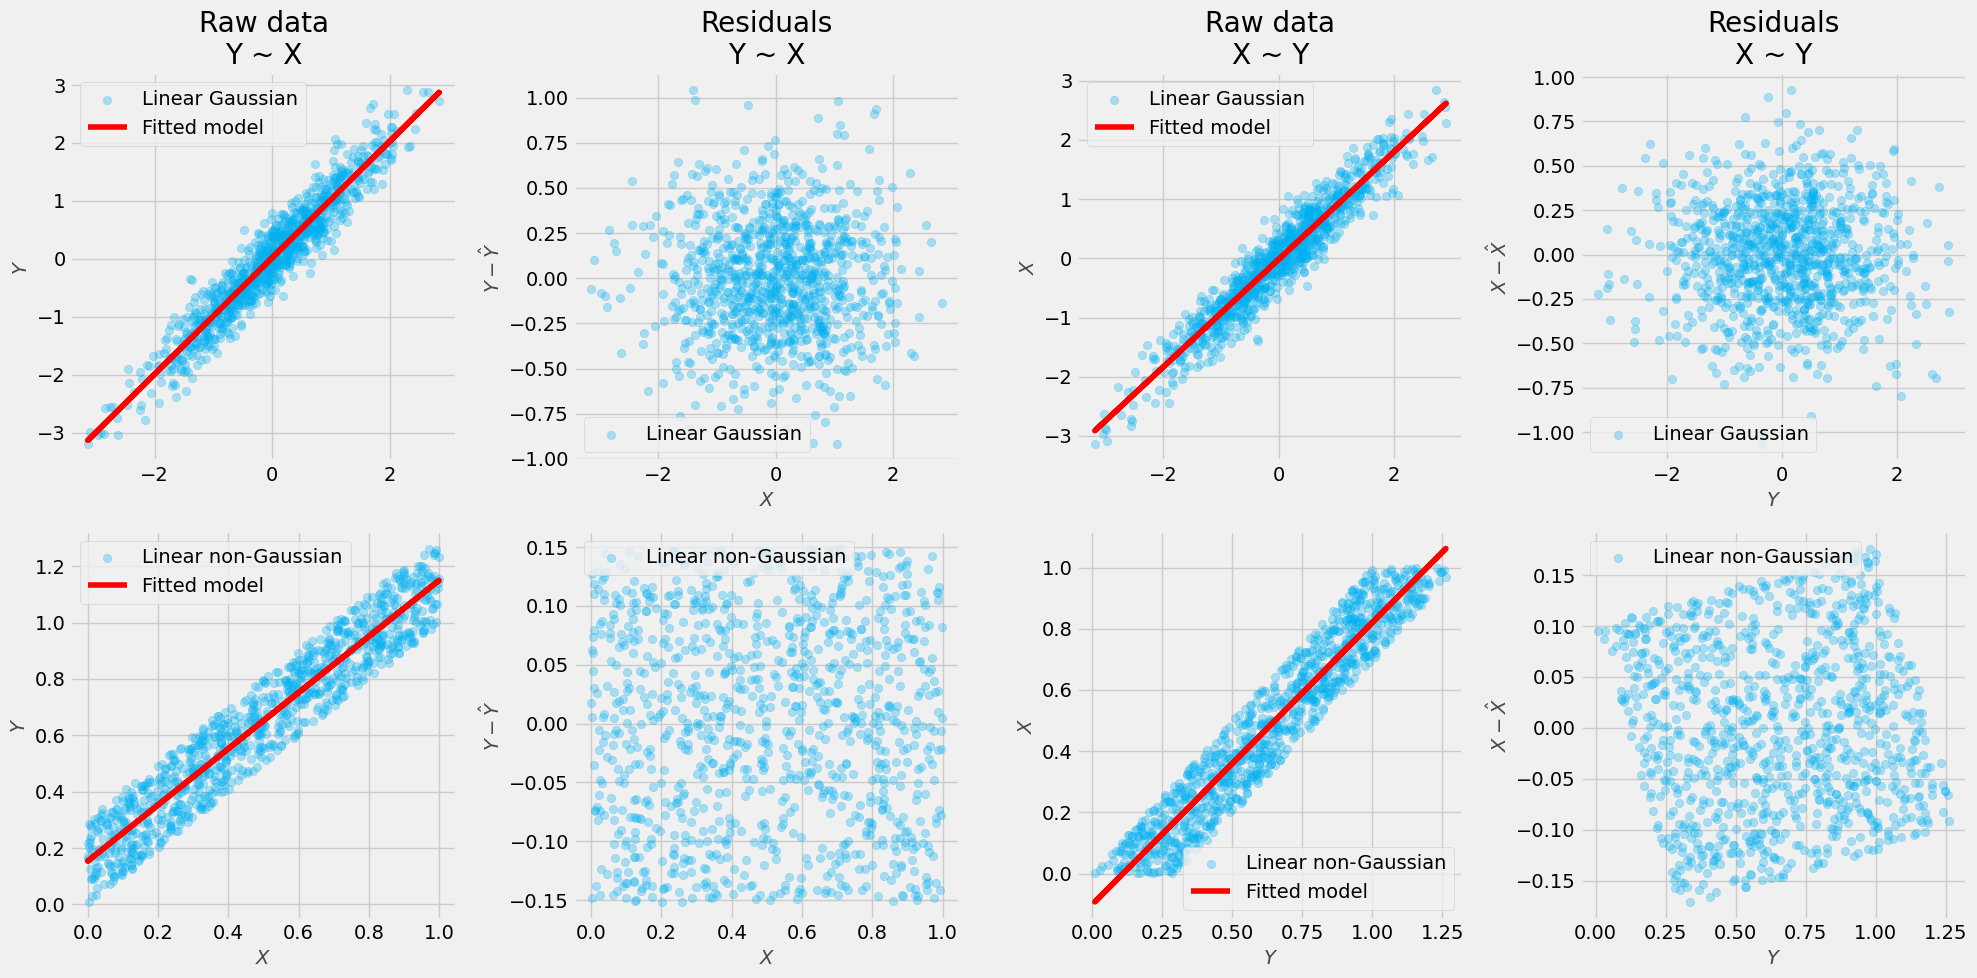

In [59]:

ALPHA = .3

# Plot the data
plt.figure(figsize=(20, 10))

# Plot X vs Y + regression lines
plt.subplot(241)
plt.scatter(x_gauss, y_gauss, label='Linear Gaussian', alpha=ALPHA, color=COLORS[0])
plt.plot(x_gauss, results['Gaussian | y ~ x'][0], color=COLORS[1], label='Fitted model')
plt.legend()
plt.ylabel('$Y$', alpha=.7, fontsize=14)
plt.title('Raw data\nY ~ X')

plt.subplot(245)
plt.scatter(x_ngauss, y_ngauss, label='Linear non-Gaussian', alpha=ALPHA, color=COLORS[0])
plt.plot(x_ngauss, results['non-Gaussian | y ~ x'][0], color=COLORS[1], label='Fitted model')
plt.xlabel('$X$', alpha=.7, fontsize=14)
plt.ylabel('$Y$', alpha=.7, fontsize=14)
plt.legend()


# Plot residuals Y ~ X
plt.subplot(242)
plt.scatter(x_gauss, results['Gaussian | y ~ x'][1], label='Linear Gaussian', color=COLORS[0], alpha=ALPHA)
plt.legend()
plt.ylabel('$Y - \hat{Y}$', alpha=.7, fontsize=14)
plt.xlabel('$X$', alpha=.7, fontsize=14)
plt.title('Residuals\nY ~ X')

plt.subplot(246)
plt.scatter(x_ngauss, results['non-Gaussian | y ~ x'][1], label='Linear non-Gaussian', color=COLORS[0], alpha=ALPHA)
plt.legend()
plt.ylabel('$Y - \hat{Y}$', alpha=.7, fontsize=14)
plt.xlabel('$X$', alpha=.7, fontsize=14)


# Plot Y vs X + regression lines
plt.subplot(243)
plt.scatter(y_gauss, x_gauss, label='Linear Gaussian', alpha=ALPHA, color=COLORS[0])
plt.plot(y_gauss, results['Gaussian | x ~ y'][0], color=COLORS[1], label='Fitted model')
plt.legend()
plt.ylabel('$X$', alpha=.7, fontsize=14)
plt.title('Raw data\nX ~ Y')

plt.subplot(247)
plt.scatter(y_ngauss, x_ngauss, label='Linear non-Gaussian', alpha=ALPHA, color=COLORS[0])
plt.plot(y_ngauss, results['non-Gaussian | x ~ y'][0], color=COLORS[1], label='Fitted model')
plt.xlabel('$Y$', alpha=.7, fontsize=14)
plt.ylabel('$X$', alpha=.7, fontsize=14)
plt.legend()


# Plot residuals X ~ Y
plt.subplot(244)
plt.scatter(y_gauss, results['Gaussian | x ~ y'][1], label='Linear Gaussian', color=COLORS[0], alpha=ALPHA)
plt.legend()
plt.xlabel('$Y$', alpha=.7, fontsize=14)
plt.ylabel('$X - \hat{X}$', alpha=.7, fontsize=14)
plt.title('Residuals\nX ~ Y')

plt.subplot(248)
plt.scatter(y_ngauss, results['non-Gaussian | x ~ y'][1], label='Linear non-Gaussian', color=COLORS[0], alpha=ALPHA)
plt.legend()
plt.xlabel('$Y$', alpha=.7, fontsize=14)
plt.ylabel('$X - \hat{X}$', alpha=.7, fontsize=14)

plt.tight_layout()
plt.show()

### LiNGAM in action

In [60]:

# Instantiate the model
lingam = ICALiNGAM(random_state=SEED)

# Fit
lingam.learn(pc_dataset)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


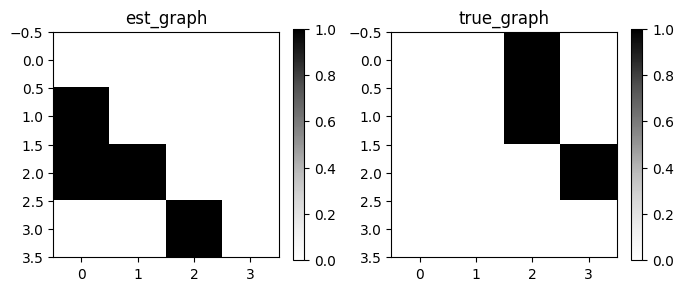

In [61]:

plt.style.use('default')

GraphDAG(
    est_dag=lingam.causal_matrix,
    true_dag=pc_dag)

plt.show()

In [62]:

lingam.weight_causal_matrix

Tensor([[ 0.   ,  0.   ,  0.   ,  0.   ],
        [-0.985,  0.   ,  0.   ,  0.   ],
        [ 0.985,  0.518,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  1.419,  0.   ]])

### Using legal data with LiNGAM

$$ \Large A := \epsilon_A$$

$$ \Large B := \epsilon_B$$

$$ \Large C := 1\times A + 1\times B + 0.1\times\epsilon_C$$

$$ \Large D := 0.7 \times C + 0.1\times\epsilon_D$$

In [63]:

N = 10000
a = np.random.uniform(0, 1, N)
b = np.random.uniform(3, 6, N)

c = a + b + .1 * np.random.uniform(-2, 0, N)
d = .7 * c + .1 * np.random.uniform(0, 1, N)

# To matrix
lingam_dataset = np.vstack([a, b, c, d]).T

In [64]:
# Instantiate the model
lingam = ICALiNGAM(random_state=SEED)

# Fit
lingam.learn(lingam_dataset)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


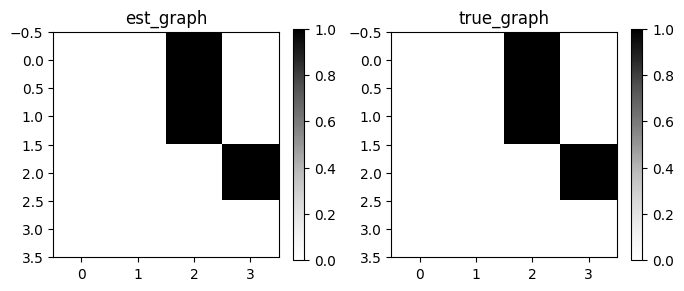

In [65]:

plt.style.use('default')

GraphDAG(
    est_dag=lingam.causal_matrix,
    true_dag=pc_dag)

plt.show()

In [66]:

lingam.weight_causal_matrix

Tensor([[0. , 0. , 1. , 0. ],
        [0. , 0. , 1. , 0. ],
        [0. , 0. , 0. , 0.7],
        [0. , 0. , 0. , 0. ]])

In [67]:
#find out help on the term
?ICALiNGAM

In [68]:
# Instantiate the model with 2000 iters
lingam = ICALiNGAM(
    max_iter=2000,
    random_state=SEED
)

In [69]:

# Fit
lingam.learn(lingam_dataset)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [70]:
lingam.weight_causal_matrix

Tensor([[0. , 0. , 1. , 0. ],
        [0. , 0. , 1. , 0. ],
        [0. , 0. , 0. , 0.7],
        [0. , 0. , 0. , 0. ]])

### Get more direct!

In [71]:

# Instantiate the model
d_lingam = DirectLiNGAM()

# Fit
d_lingam.learn(lingam_dataset)

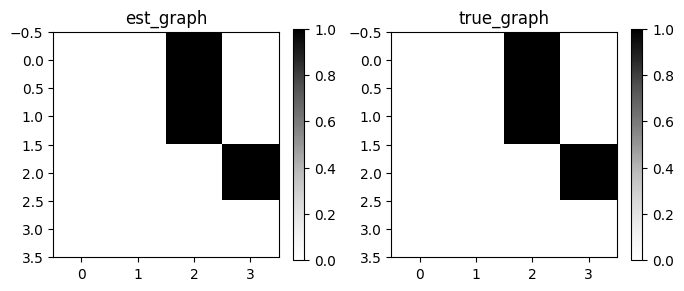

In [72]:
plt.style.use('default')

GraphDAG(
    est_dag=d_lingam.causal_matrix,
    true_dag=pc_dag)

plt.show()

In [73]:

d_lingam.weight_causal_matrix

Tensor([[0. , 0. , 1. , 0. ],
        [0. , 0. , 1. , 0. ],
        [0. , 0. , 0. , 0.7],
        [0. , 0. , 0. , 0. ]])

## Gradient-based causal discovery

In [75]:

def check_if_dag(adj_matrix):
    A = adj_matrix
    return np.trace(linalg.expm(A * A)) - A.shape[0] == 0

In [76]:
check_if_dag(pc_dag)

True

In [77]:
dcg = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 1, 0]
])

In [78]:
check_if_dag(dcg)

False

### The shootout

In [79]:
# Data simulation, simulate true causal dag and train_data.
true_dag = DAG.scale_free(n_nodes=10, n_edges=15, seed=SEED)


DATA_PARAMS = {
    'linearity': ['linear', 'nonlinear'],
    'distribution': {
        'linear': ['gauss', 'exp'],
        'nonlinear': ['quadratic']
    }
}

datasets = {}

for linearity in DATA_PARAMS['linearity']:
    for distr in DATA_PARAMS['distribution'][linearity]:

        datasets[f'{linearity}_{distr}'] = IIDSimulation(
            W=true_dag,
            n=2000,
            method=linearity,
            sem_type=distr)

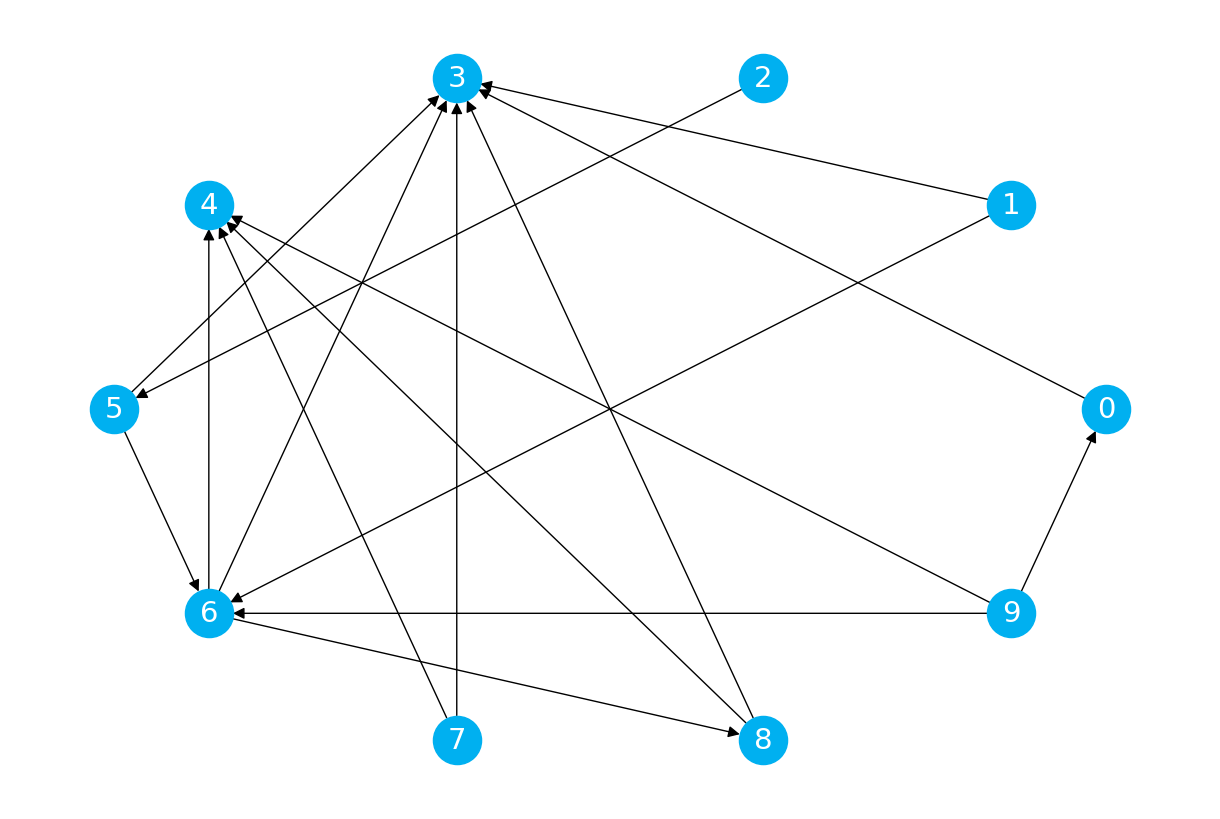

In [80]:
g = nx.DiGraph(true_dag)

plt.figure(figsize=(12, 8))
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

In [83]:
# Pick the methods
methods = OrderedDict({
    'PC': PC,
    'GES': GES
   # ,
   # 'LiNGAM': DirectLiNGAM,
   # 'Notears': NotearsNonlinear,
   # 'GOLEM': GOLEM
})

##When we consider all the methods the cell can take significant time to execute , so we can start with two methods and then uncomment one by one to
##compare the results

************* Current dataset: linear_gauss

Method: PC


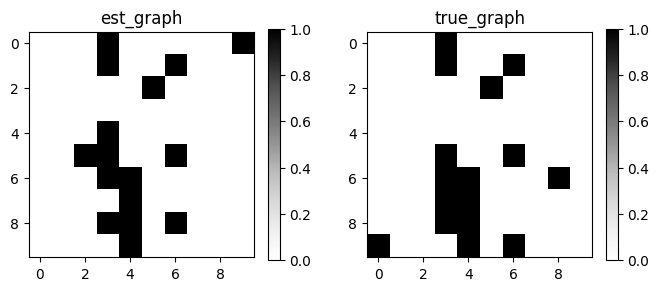

FDR: 0.2
Recall: 0.75
Precision: 0.75
F1 score: 0.75
SHD score: 5
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: GES


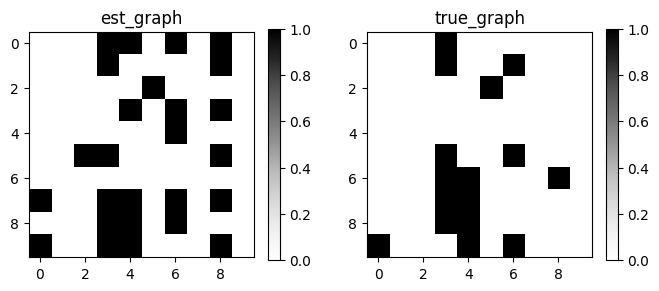

FDR: 0.5833
Recall: 0.625
Precision: 0.3846
F1 score: 0.4762
SHD score: 17
No. of undir. edges: 2.0

-------------------------------------------------- 



************* Current dataset: linear_exp

Method: PC


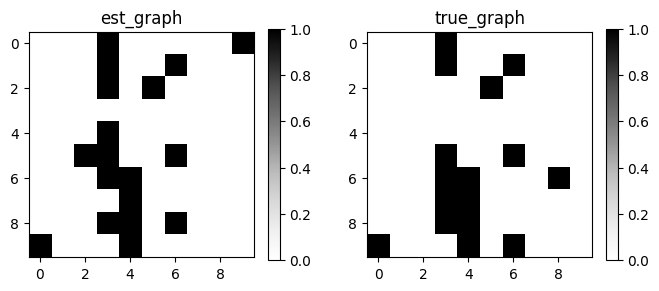

FDR: 0.1875
Recall: 0.8125
Precision: 0.7222
F1 score: 0.7647
SHD score: 5
No. of undir. edges: 2.0

-------------------------------------------------- 

Method: GES


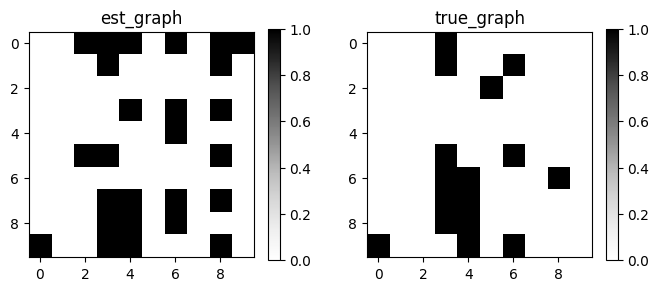

FDR: 0.625
Recall: 0.5625
Precision: 0.3462
F1 score: 0.4286
SHD score: 18
No. of undir. edges: 2.0

-------------------------------------------------- 



************* Current dataset: nonlinear_quadratic

Method: PC


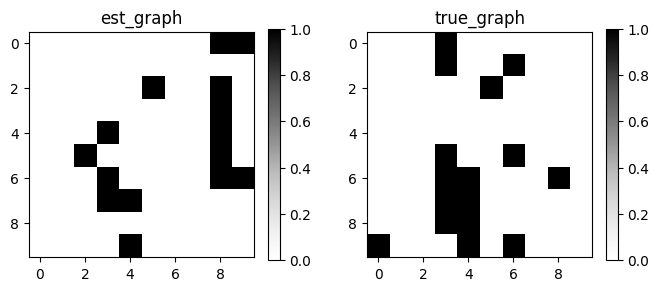

FDR: 0.5714
Recall: 0.375
Precision: 0.4
F1 score: 0.3871
SHD score: 14
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: GES


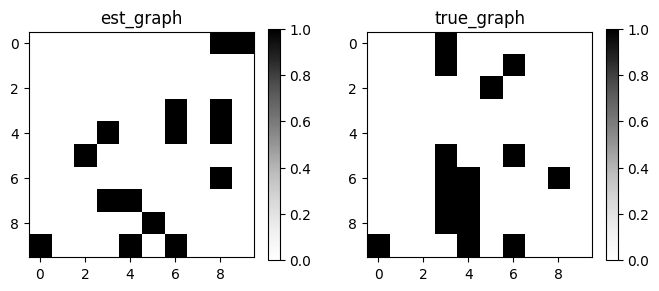

FDR: 0.5714
Recall: 0.375
Precision: 0.4
F1 score: 0.3871
SHD score: 13
No. of undir. edges: 1.0

-------------------------------------------------- 





In [84]:

results = {}

for k, dataset in datasets.items():
    print(f'************* Current dataset: {k}\n')
    X = dataset.X

    results[dataset] = {}

    for method in methods:

        print(f'Method: {method}')

        # Fit the model
        if method == 'GOLEM':
            model = methods[method](num_iter=2.5e4)
        else:
            model = methods[method]()

        # Fit the model
        model.learn(X)

        # Get the DAG
        pred_dag = model.causal_matrix

        # Get n undir edges
        n_undir = get_n_undirected(pred_dag)

        # Plot results
        GraphDAG(pred_dag, true_dag, 'result')

        mt = MetricsDAG(pred_dag, true_dag)
        print(f'FDR: {mt.metrics["fdr"]}')
        print(f'Recall: {mt.metrics["recall"]}')
        print(f'Precision: {mt.metrics["precision"]}')
        print(f'F1 score: {mt.metrics["F1"]}')
        print(f'SHD score: {mt.metrics["shd"]}')
        print(f'No. of undir. edges: {n_undir}\n')
        print('-' * 50, '\n')

        results[dataset][method] = pred_dag

    print('\n')

## Encoding expert knowledge

### `PC`

In [85]:
# Instantiate and encode priori knowledge
priori_knowledge = PrioriKnowledge(n_nodes=10)

# Add required & forbidden edges
priori_knowledge.add_required_edges([(7, 3)])
priori_knowledge.add_forbidden_edges([(0, 9), (8, 6)])

In [86]:
# Instantiate the model with expert knowledge
pc_priori = PC(priori_knowledge=priori_knowledge)

# Learn
pc_priori.learn(datasets['linear_gauss'].X)

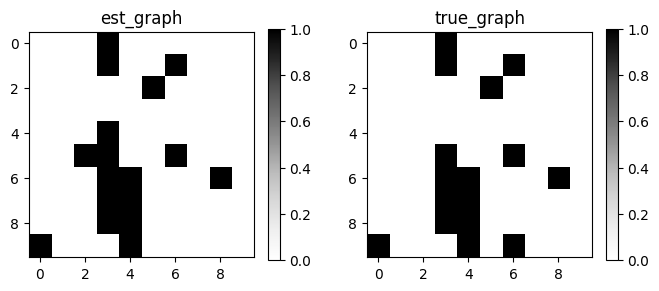

In [87]:
# Plot the results
plt.style.use('default')

GraphDAG(
    est_dag=pc_priori.causal_matrix,
    true_dag=true_dag)

plt.show()

In [88]:
# Compute metrics
mt = MetricsDAG(pc_priori.causal_matrix, true_dag)
print(f'FDR: {mt.metrics["fdr"]}')
print(f'Recall: {mt.metrics["recall"]}')
print(f'Precision: {mt.metrics["precision"]}')
print(f'F1 score: {mt.metrics["F1"]}')
print(f'SHD score: {mt.metrics["shd"]}')
print(f'No. of undir. edges: {n_undir}\n')

FDR: 0.0625
Recall: 0.9375
Precision: 0.8824
F1 score: 0.9091
SHD score: 2
No. of undir. edges: 1.0

